# Spaceship Titanic - Challenge

This is an evolution of the Titanic entry challenge on Kaggle. I want to train using a Deep Neural Network Model (DNN model) and the Keras Tuner. It will closely follow what I had done for the Titanic challenge, except that it will make use of the tuner later.

In [131]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

In [177]:
train_data_raw = pd.read_csv("../Datasets/spaceship-Titanic/train.csv")
test_data_raw = pd.read_csv("../Datasets/spaceship-Titanic/test.csv")

column_names = train_data_raw.columns
print(column_names)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


### Missing data

<AxesSubplot:>

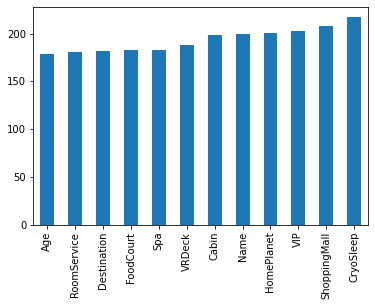

In [133]:
missing = train_data_raw.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

There are missing data in all explanatory variables except for the passenger ID. Let's do a small analysis of the response variable, `Transported`. To start, this variable does not contain missing data.

In [134]:
train_data_raw['Transported'].describe()

count     8693
unique       2
top       True
freq      4378
Name: Transported, dtype: object

So, about half the passengers in the training dataset were transported to another dimension. Let's start by dropping a few useless variables, namely Passenger ID and Name.

In [178]:
train_data = train_data_raw.drop(['PassengerId', 'Name'], axis=1)

We also need to encode some data. Let's look at the distributions of the luxury amenities:

c:\Users\xtomma\Anaconda3\envs\machinelearning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\xtomma\Anaconda3\envs\machinelearning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\xtomma\Anaconda3\envs\machinelearning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

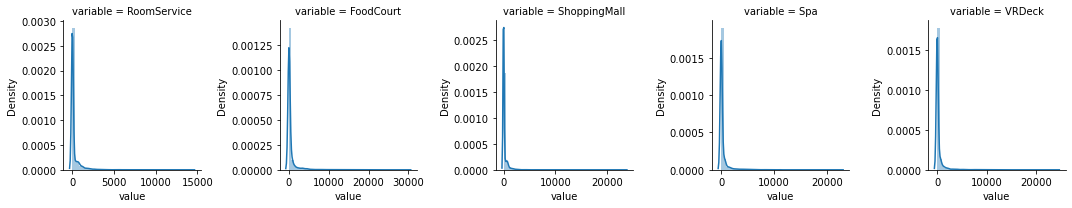

In [179]:
luxury = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
f = pd.melt(train_data, value_vars=luxury)
g = sns.FacetGrid(f, col='variable', col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

From this it seems that most people used very little these possibilities. But is this relevant? 

The numerical variables are: Age, RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck.
The boolean variables are: CryoSleep, VIP, Transported (response)
The categorical variables are: HomePlanet, Cabin, Destination

First we need to deal with Cabin to split it into 3 variables, as it's a composed variable.

### The Cabin variable

We need to encode the Cabin variable in such a way that each of the three represented variables is a different number. First, then, let's separate the variable in three.

In [164]:
train_data['Cabin'].head()

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object

For each entry `entry`, the deck is represented by `entry[0]`, the port by `entry[2]` and the starboard by `entry[4]`. Let's encode these in different variables then.

In [180]:
train_data[['Deck', 'Port', 'Starboard']] = train_data['Cabin'].str.split("/", expand=True)
train_data = train_data.drop(['Cabin'], axis=1)

In [181]:
test_data_raw[['Deck', 'Port', 'Starboard']] = test_data_raw['Cabin'].str.split("/", expand=True)
test_data = test_data_raw.drop(['Cabin'], axis=1)
test_data = test_data.drop(['PassengerId', 'Name'], axis=1)

Next, we encode categorical variables as numbers? I like one-hot encoding, so that's what I'm gonna do:

In [182]:
train_data = pd.get_dummies(train_data, columns=['Destination', 'HomePlanet', 'Deck', 'Port', 'Starboard'])
test_data = pd.get_dummies(test_data, columns=['Destination', 'HomePlanet', 'Deck', 'Port', 'Starboard'])

We drop all columns that are not found in `test_data`, to ensure that prediction can be performed at the end.

In [183]:
train_data = train_data.drop(train_data.columns[~train_data.columns.isin(test_data.columns)], 1)

C:\Users\xtomma\AppData\Local\Temp\ipykernel_15200\2117273452.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_data = train_data.drop(train_data.columns[~train_data.columns.isin(test_data.columns)], 1)


In [185]:
print(train_data.columns)
print(test_data.columns)

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       ...
       'Port_99', 'Port_990', 'Port_992', 'Port_993', 'Port_994', 'Port_995',
       'Port_996', 'Port_997', 'Starboard_P', 'Starboard_S'],
      dtype='object', length=1452)
Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       ...
       'Port_99', 'Port_990', 'Port_992', 'Port_993', 'Port_994', 'Port_995',
       'Port_996', 'Port_997', 'Starboard_P', 'Starboard_S'],
      dtype='object', length=1529)


This leads to two dataframes with different number of columns! This means that the test set has categories that the train dataset does not have. Where exactly?

In [189]:
test_data.columns[~test_data.columns.isin(train_data.columns)]

Index(['Port_1042', 'Port_1110', 'Port_1157', 'Port_1182', 'Port_1222',
       'Port_1291', 'Port_1401', 'Port_1443', 'Port_1516', 'Port_1524',
       'Port_1530', 'Port_1542', 'Port_1556', 'Port_1563', 'Port_1565',
       'Port_1568', 'Port_1573', 'Port_1580', 'Port_1581', 'Port_1589',
       'Port_1590', 'Port_1623', 'Port_1631', 'Port_1641', 'Port_1649',
       'Port_1650', 'Port_1656', 'Port_1662', 'Port_1692', 'Port_1698',
       'Port_1714', 'Port_1728', 'Port_1730', 'Port_1732', 'Port_1757',
       'Port_1759', 'Port_1760', 'Port_1762', 'Port_1764', 'Port_1785',
       'Port_1790', 'Port_1791', 'Port_1795', 'Port_1796', 'Port_1801',
       'Port_1803', 'Port_1806', 'Port_1809', 'Port_1811', 'Port_1813',
       'Port_1814', 'Port_1827', 'Port_1833', 'Port_1835', 'Port_1836',
       'Port_1843', 'Port_1845', 'Port_1849', 'Port_1850', 'Port_1851',
       'Port_1852', 'Port_1854', 'Port_1859', 'Port_1860', 'Port_1861',
       'Port_1862', 'Port_1869', 'Port_1874', 'Port_1879', 'Port

These are all `'Port'` features, which is then unlikely to be significant as it stands. I think we should drop the `'Port'` feature completely. Let's redefine the whole dataset:

In [190]:
train_data = train_data_raw.drop(['PassengerId', 'Name'], axis=1)
test_data = test_data_raw.drop(['PassengerId', 'Name'], axis=1)

train_data[['Deck', 'Port', 'Starboard']] = train_data['Cabin'].str.split("/", expand=True)
train_data = train_data.drop(['Cabin', 'Port'], axis=1)
test_data[['Deck', 'Port', 'Starboard']] = test_data['Cabin'].str.split("/", expand=True)
test_data = test_data.drop(['Cabin', 'Port'], axis=1)

train_data = pd.get_dummies(train_data, columns=['Destination', 'HomePlanet', 'Deck', 'Starboard'])
test_data = pd.get_dummies(test_data, columns=['Destination', 'HomePlanet', 'Deck', 'Starboard'])

And to be sure we drop all columns that aren't found in `test_data`.

In [191]:
train_data = train_data.drop(train_data.columns[~train_data.columns.isin(test_data.columns)], 1)

C:\Users\xtomma\AppData\Local\Temp\ipykernel_15200\2117273452.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_data = train_data.drop(train_data.columns[~train_data.columns.isin(test_data.columns)], 1)


In [192]:
train_data.shape[1] == test_data.shape[1]

True

### a) fill NAs

`'CryoSleep'` and `'VIP'` are booleans, so we fill them with 0s. Because all the `luxury` variables have mostly 0, we do the same. All the categorical variables will also be filled with 0. We will fill only `'Age'` with the mean. 

In [193]:
for column in train_data.columns:
    if column == 'Age':
        train_data[column] = train_data[column].fillna(np.nanmean(train_data['Age']))
    else: 
        train_data[column] = train_data[column].fillna(0)

for column in test_data.columns:
    if column == 'Age':
        test_data[column] = test_data[column].fillna(np.nanmean(test_data['Age']))
    else: 
        test_data[column] = test_data[column].fillna(0)


### b) turn booleans into 0 and 1

In [194]:
train_data[['CryoSleep', 'VIP']]

,CryoSleep,VIP
0,False,False
1,False,False
2,False,True
3,False,False
4,False,False
...,...,...
8688,False,True
8689,True,False
8690,False,False
8691,False,False


In [195]:
train_data['CryoSleep'] = train_data['CryoSleep'].apply(lambda x: int(x))
train_data['VIP'] = train_data['VIP'].apply(lambda x: int(x))

test_data['CryoSleep'] = test_data['CryoSleep'].apply(lambda x: int(x))
test_data['VIP'] = test_data['VIP'].apply(lambda x: int(x))

### c) categorize `luxury` variables

In [196]:
for column in luxury:
    train_data[column] = train_data[column].map(lambda x: 0 if x == 0 else 1)
    test_data[column] = test_data[column].map(lambda x: 0 if x == 0 else 1)

In [197]:
train_data[luxury]

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,0,0,0,0
1,1,1,1,1,1
2,1,1,0,1,1
3,0,1,1,1,1
4,1,1,1,1,1
...,...,...,...,...,...
8688,0,1,0,1,1
8689,0,0,0,0,0
8690,0,0,1,1,0
8691,0,1,0,1,1


## Train model

In [200]:
# rename for modelling
train_features = train_data
train_labels = train_data_raw['Transported']

We apply a normalization layer:

In [201]:
normalizer = layers.Normalization(input_shape=[train_features.shape[1],], axis=-1)
normalizer.adapt(np.array(train_features))

In [202]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(normalizer)
    
    hp_units_1 = hp.Int('units_1', min_value=128, max_value=512, step=32)
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    model.add(keras.layers.Dense(units=hp_units_1, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

    return model


Let's start the tuning.

In [203]:
tuner = kt.Hyperband(model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='tuner',
                     project_name='space-titanic',
                     overwrite=True)

In [204]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_binary_loss', patience=5)

In [205]:
tuner.search(train_features,
             train_labels,
             epochs=20,
             validation_split=0.2,
             callbacks=[stop_early])

Trial 30 Complete [00h 00m 22s]
val_binary_accuracy: 0.7630822062492371

Best val_binary_accuracy So Far: 0.7682576179504395
Total elapsed time: 00h 04m 26s
INFO:tensorflow:Oracle triggered exit


In [206]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the densely-connected layers is {best_hps.get('units_1')} and {best_hps.get('units_2')}, and the optimal learning_rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the densely-connected layers is 320 and 32, and the optimal learning_rate for the optimizer is 0.01.



## Train the model

In [207]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_features, train_labels, epochs=50, validation_split=0.2)

Epoch 1/50
218/218 [==============================] - 2s 5ms/step - loss: 0.5571 - binary_accuracy: 0.7158 - val_loss: 0.5199 - val_binary_accuracy: 0.7539
Epoch 2/50
218/218 [==============================] - 1s 4ms/step - loss: 0.5431 - binary_accuracy: 0.7092 - val_loss: 0.5158 - val_binary_accuracy: 0.7384
Epoch 3/50
218/218 [==============================] - 1s 4ms/step - loss: 0.5414 - binary_accuracy: 0.7141 - val_loss: 0.5122 - val_binary_accuracy: 0.7545
Epoch 4/50
218/218 [==============================] - 1s 4ms/step - loss: 0.5427 - binary_accuracy: 0.7196 - val_loss: 0.5106 - val_binary_accuracy: 0.7504
Epoch 5/50
218/218 [==============================] - 1s 4ms/step - loss: 0.5399 - binary_accuracy: 0.7186 - val_loss: 0.4933 - val_binary_accuracy: 0.7637
Epoch 6/50
218/218 [==============================] - 1s 4ms/step - loss: 0.5422 - binary_accuracy: 0.7157 - val_loss: 0.5126 - val_binary_accuracy: 0.7447
Epoch 7/50
218/218 [==============================] - 1s 4ms/ste

In [208]:
val_accuracy = history.history['val_binary_accuracy']
best_epoch = val_accuracy.index(max(val_accuracy)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 28


In [209]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(train_features, train_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/28
218/218 [==============================] - 2s 5ms/step - loss: 0.5571 - binary_accuracy: 0.7115 - val_loss: 0.4993 - val_binary_accuracy: 0.7539
Epoch 2/28
218/218 [==============================] - 1s 4ms/step - loss: 0.5400 - binary_accuracy: 0.7186 - val_loss: 0.4994 - val_binary_accuracy: 0.7510
Epoch 3/28
218/218 [==============================] - 1s 4ms/step - loss: 0.5382 - binary_accuracy: 0.7213 - val_loss: 0.5038 - val_binary_accuracy: 0.7441
Epoch 4/28
218/218 [==============================] - 1s 4ms/step - loss: 0.5395 - binary_accuracy: 0.7186 - val_loss: 0.4998 - val_binary_accuracy: 0.7602
Epoch 5/28
218/218 [==============================] - 1s 4ms/step - loss: 0.5388 - binary_accuracy: 0.7196 - val_loss: 0.5004 - val_binary_accuracy: 0.7642
Epoch 6/28
218/218 [==============================] - 1s 4ms/step - loss: 0.5397 - binary_accuracy: 0.7117 - val_loss: 0.5114 - val_binary_accuracy: 0.7516
Epoch 7/28
218/218 [==============================] - 1s 4ms/ste

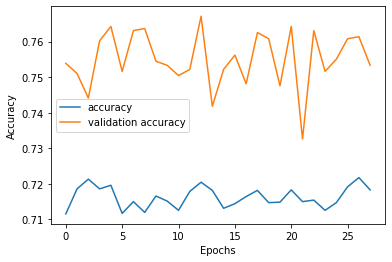

In [210]:
plt.plot(hypermodel.history.history['binary_accuracy'], label='accuracy')
plt.plot(hypermodel.history.history['val_binary_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

With the model trained, let's evaluate the test data.

In [211]:
predictions = (hypermodel.predict(test_data) > 0.5).astype("int32")
predictions[:,0]

output = pd.DataFrame({'PassengerId': test_data_raw.PassengerId, 'Survived': predictions[:,0]})
output.to_csv('tuner_submission.csv', index=False)

134/134 [==============================] - 0s 2ms/step
